<a href="https://colab.research.google.com/github/labviaunb/ermac-sc/blob/main/train_rrwnet_swin_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1. Instalando os pacotes e carregando o google drive
!pip install -q "monai[einops]" torch torchvision matplotlib opencv-python scikit-image scipy

import os
import shutil
import zipfile
import glob
from google.colab import drive
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    ToTensord,
    MapTransform,
    Resized
)
from monai.data import decollate_batch
from PIL import Image
from skimage import io, morphology, measure
import scipy.ndimage as ndimage
from scipy.interpolate import interp1d

# GOOGLE DRIVE PATH
DRIVE_ZIP_PATH = "/content/drive/MyDrive/Colab/Fundus-AVSeg_1280.zip"

def mount_and_extract(zip_path_in_drive):
    print("Montando Google Drive:")
    drive.mount('/content/drive')

    if not os.path.exists(zip_path_in_drive):
        print(f"\nERRO: Arquivo não encontrado em: {zip_path_in_drive}")
        print("Verifique se o nome do arquivo está correto e se ele está no seu Drive.")
        return None, None

    if os.path.exists("dataset"):
        shutil.rmtree("dataset")
    os.makedirs("dataset", exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path_in_drive, 'r') as zip_ref:
            zip_ref.extractall("dataset")
        print("Extração concluída!")
    except zipfile.BadZipFile:
        print("ERRO: O arquivo parece estar corrompido ou não é um zip válido.")
        return None, None

    base_dir = "dataset"

    if not os.path.exists(os.path.join(base_dir, "images_1280")):
        subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        if len(subdirs) == 1:
            base_dir = os.path.join(base_dir, subdirs[0])
            print(f"Ajustando diretório base para: {base_dir}")

    img_dir = os.path.join(base_dir, "images_1280")
    mask_dir = os.path.join(base_dir, "annotation_1280")

    if os.path.exists(img_dir) and os.path.exists(mask_dir):
        print(f"\nDiretórios configurados com sucesso:\n - Imagens: {img_dir}\n - Máscaras: {mask_dir}")
        return img_dir, mask_dir
    else:
        print(f"\nERRO: Pastas 'images_1280' ou 'annotation_1280' não encontradas dentro do zip.")
        print(f"Conteúdo extraído em {base_dir}: {os.listdir(base_dir)}")
        return None, None

img_dir, mask_dir = mount_and_extract(DRIVE_ZIP_PATH)

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Extraindo /content/drive/MyDrive/Colab/Fundus-AVSeg_1280.zip para o ambiente local...
Extração concluída!

Diretórios configurados com sucesso:
 - Imagens: dataset/images_1280
 - Máscaras: dataset/annotation_1280


In [ ]:
# @title 2. Setup inicial

# Mudando devide para o CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMAGES_PATH = img_dir
MASKS_PATH = mask_dir

FULL_IMG_SIZE = (1280, 1280)
PATCH_SIZE = (640, 640) # Tamanho dos retalhos
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-2 # Default do AdamW
MAX_EPOCHS = 150
K_ITERATIONS = 1 # Número de refinamentos
FEATURES_SIZE = 60

# Fixando a semente
import random
SEED = 42

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Semente fixada em {seed}")

set_seed(SEED)

Using device: cuda
Seed fixed to 42


In [ ]:
# @title 3. Funções de pré-processamento
def crop_center(img, cropx, cropy):
    y, x = img.shape[0], img.shape[1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def to_0_1(img):
    val_min = img.min()
    val_max = img.max()
    if val_max - val_min == 0:
        return img
    return (img - val_min) / (val_max - val_min)

def get_fov_mask(img_np, threshold=0.05): # Ajuste o threshold caso a binarização não esteja boa
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    if len(img_np.shape) == 3:
        gray = np.mean(img_np, axis=2)
    else:
        gray = img_np

    binary_mask = gray > threshold

    labels = measure.label(binary_mask)
    props = measure.regionprops(labels)

    if not props:
        return np.zeros(img_np.shape[:2], dtype=np.float32)

    largest_component = props[np.argmax([p.area for p in props])]
    mask = labels == largest_component.label

    mask = ndimage.binary_fill_holes(mask)
    mask = morphology.binary_erosion(mask, morphology.disk(3))

    return mask.astype(np.float32)

def enhance_image(img, mask=None):
    if img.max() > 1.0:
        img = img / 255.0

    if mask is None:
        mask = get_fov_mask(img)

    # 1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # Ajuda a destacar vasos antes da subtração gaussiana, mas amplifica ruído
    # Considerar não usar o CLAHE (No RRWNet ele não usa)
    img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    if len(img.shape) == 3 and img.shape[2] == 3:
        lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)

        lab_merged = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2RGB)

        img = img_clahe.astype(np.float32) / 255.0
    # ------------------------------------------------------------------------

    mask = (mask > 0.5).astype(np.float32)
    if len(img.shape) == 3:
        mask_bc = np.stack([mask]*3, axis=-1)
    else:
        mask_bc = mask

    # 2. Subtração Gaussiana (sigma=10)
    if len(img.shape) == 3:
        img_blurred = ndimage.gaussian_filter(img, sigma=(10, 10, 0))
    else:
        img_blurred = ndimage.gaussian_filter(img, sigma=10)

    img_subtracted = img - img_blurred

    # 3. Multiplicação pela máscara binária
    img_masked = img_subtracted * mask_bc

    # 4. Normalização por média e variância (apenas pixels dentro da máscara)
    valid_pixels = img_masked[mask_bc == 1]

    if valid_pixels.size > 0:
        mean_val = np.mean(valid_pixels)
        std_val = np.std(valid_pixels)
        if std_val == 0: std_val = 1.0

        # Padronização (z-score)
        img_normalized = (img_masked - mean_val) / std_val
    else:
        img_normalized = img_masked

    # Aplica máscara novamente para limpar o fundo (que pode ter mudado com a subtração da média)
    img_normalized = img_normalized * mask_bc

    # Mapear para 0-1 para compatibilidade com o resto do pipeline (visualização/rede)
    # APENAS PARA PIXELS DENTRO DO FOV
    if valid_pixels.size > 0:
        min_val_fov = img_normalized[mask_bc == 1].min()
        max_val_fov = img_normalized[mask_bc == 1].max()
        if (max_val_fov - min_val_fov) == 0:
            enhanced_image = img_normalized
        else:
            enhanced_image = (img_normalized - min_val_fov) / (max_val_fov - min_val_fov)
            enhanced_image = enhanced_image * mask_bc
    else:
        enhanced_image = img_normalized

    # Garantia final de fundo zero
    enhanced_image = enhanced_image * mask_bc

    return enhanced_image.astype(np.float32)

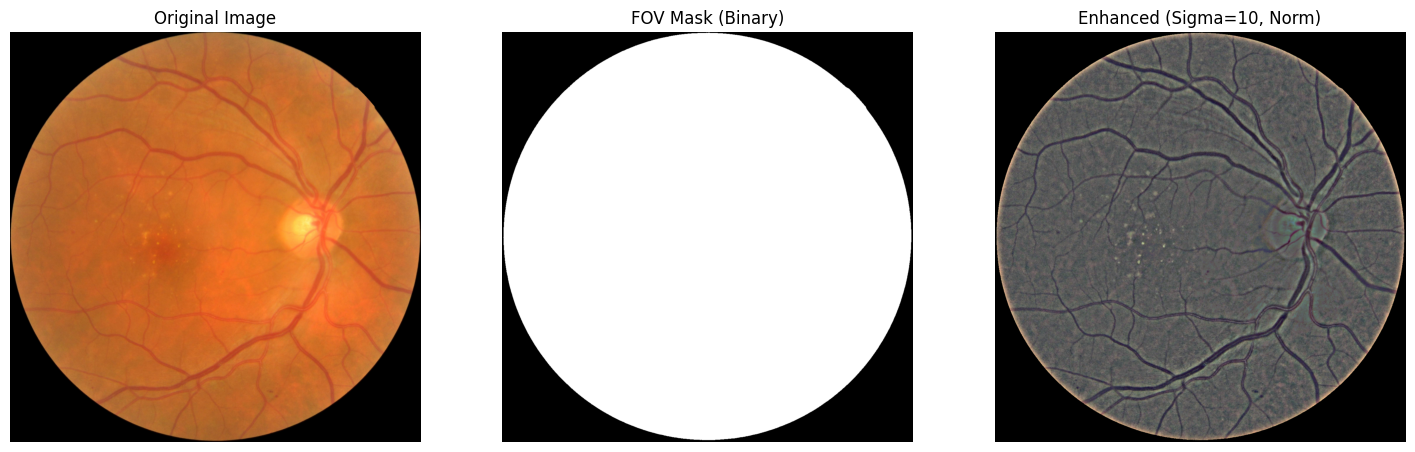

In [ ]:
# @title Visualização do Pré-processamento
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage import io

# Selecionar uma imagem de exemplo
sample_images = sorted(glob.glob(os.path.join(img_dir, "*.png")))
if len(sample_images) > 0:
    img_path = sample_images[12]
    original_img = io.imread(img_path)

    # Converter para float 0-1 se necessário para visualização consistente
    if original_img.max() > 1:
        original_img = original_img / 255.0

    # Gerar Máscara
    mask = get_fov_mask(original_img)

    # Gerar Imagem Realçada
    enhanced_img = enhance_image(original_img, mask)

    # Plotar
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Raw Image")
    plt.imshow(original_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Binary Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Enhanced Image")
    plt.imshow(enhanced_img)
    plt.axis("off")

    plt.show()
else:
    print("Nenhuma imagem encontrada para visualização.")

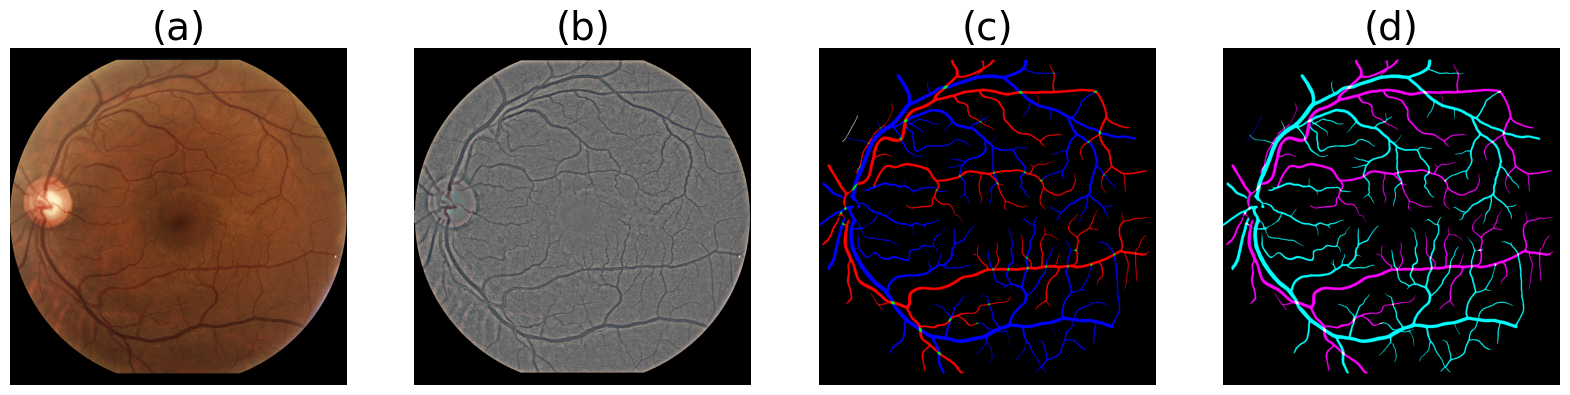

Cores presentes na nova máscara:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]


In [ ]:
# @title 4. Visualização e Teste do Novo Mapeamento de Máscaras

def convert_mask_new_encoding(mask_original):
    # Normalizar se necessário
    if mask_original.max() > 1:
        mask = mask_original / 255.0
    else:
        mask = mask_original.copy()

    # Extrair canais originais
    r = mask[..., 0]
    g = mask[..., 1]
    b = mask[..., 2]

    # Identificar classes baseado nas cores originais
    # Branco (Unknown): R=1, G=1, B=1
    is_unknown = (r > 0.5) & (g > 0.5) & (b > 0.5)

    # Vermelho (Arteria): R=1, G=0, B=0
    is_artery = (r > 0.5) & (g < 0.5) & (b < 0.5)

    # Azul (Veia): R=0, G=0, B=1
    is_vein = (r < 0.5) & (g < 0.5) & (b > 0.5)

    # Verde (Interseção): R=0, G=1, B=0
    is_inter = (r < 0.5) & (g > 0.5) & (b < 0.5)

    # Ajuste da máscara Ground Truth
    # 1. Canal Azul (B_out): Todos os vasos (árvore vascular)
    # Representa a união de todos
    target_b = is_artery | is_vein | is_inter | is_unknown

    # 2. Canal Vermelho (R_out): Artéria + Interseção
    target_r = is_artery | is_inter

    # 3. Canal Verde (G_out): Veia + Interseção
    target_g = is_vein | is_inter

    # Stack (H, W, 3)
    new_mask = np.stack([target_r, target_g, target_b], axis=-1).astype(np.float32)
    return new_mask

# Selecionar uma imagem de exemplo e sua máscara correspondente
image_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

if len(image_files) > 0 and len(mask_files) > 0:
    # Pegar um índice de exemplo (pode ajustar para testar outras imagens)
    idx = 1 # Usando o segundo elemento da lista para evitar o primeiro que pode ser um caso trivial

    sample_img_path = image_files[idx]
    sample_mask_path = mask_files[idx]

    # 1. Carregar imagem original
    original_img = io.imread(sample_img_path)
    if original_img.max() > 1:
        original_img_float = original_img / 255.0
    else:
        original_img_float = original_img.copy()

    # 2. Gerar FOV mask e imagem pré-processada
    fov_mask = get_fov_mask(original_img_float)
    enhanced_img = enhance_image(original_img_float, mask=fov_mask)

    # 3. Carregar máscara ground truth original
    original_mask = io.imread(sample_mask_path)

    # 4. Gerar nova máscara ajustada
    new_mask = convert_mask_new_encoding(original_mask)

    # Ajustar tamanho global da fonte para melhor leitura
    plt.rc('font', size=12) # Define o tamanho da fonte globalmente

    # Plotar todas as quatro imagens em uma linha
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title("(a)", fontsize=28)
    plt.imshow(original_img_float)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("(b)", fontsize=28)
    plt.imshow(enhanced_img)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("(c)", fontsize=28)
    plt.imshow(original_mask)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("(d)", fontsize=28)
    plt.imshow(new_mask)
    plt.axis("off")

    plt.show()

else:
    print("Nenhuma imagem ou máscara encontrada para visualização. Verifique os diretórios.")

In [ ]:
# @title 5. Loss

# Extraído do paper: "RRWNet: Recursive Refinement Network for Effective Retinal
# Artery/Vein Segmentation and Classification", by José Morano, Guilherme Aresta,
# and Hrvoje Bogunović, published in Expert Systems with Applications (2024).
# https://github.com/j-morano/rrwnet

class BCE3Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred_vessels, vessels, mask):
        mask = mask[:, 0, :, :]
        mask = torch.round(mask)

        pred_a = pred_vessels[:, 0, :, :]
        pred_v = pred_vessels[:, 1, :, :]
        pred_vt = pred_vessels[:, 2, :, :]

        gt_a = vessels[:, 0, :, :]
        gt_v = vessels[:, 1, :, :]
        gt_vt = vessels[:, 2, :, :]

        uncertain = gt_vt - gt_v - gt_a
        uncertain[uncertain < 0] = 0

        mask_unknown = mask - uncertain
        mask_unknown[mask_unknown < 0] = 0

        loss = 0
        if mask_unknown.sum() > 0:
            loss += self.loss(pred_a[mask_unknown > 0.5], gt_a[mask_unknown > 0.5])
            loss += self.loss(pred_v[mask_unknown > 0.5], gt_v[mask_unknown > 0.5])

        if mask.sum() > 0:
            loss += self.loss(pred_vt[mask > 0.], gt_vt[mask > 0.])

        return loss

class RRLoss(nn.Module):
    def __init__(self, base_criterion):
        super().__init__()
        self.base_criterion = base_criterion

    def forward(self, predictions, gt, mask=None):
        loss_1 = self.base_criterion(predictions[0], gt, mask)

        if len(predictions) == 1:
            return loss_1

        loss_2 = 1 * self.base_criterion(predictions[1], gt, mask)

        if len(predictions) == 2:
            return loss_1 + loss_2

        for i, prediction in enumerate(predictions[2:], 2):
            loss_2 += i * self.base_criterion(prediction, gt, mask)

        K = len(predictions[1:])
        Z = (1/2) * K * (K + 1)

        loss_2 *= 1/Z

        loss = loss_1 + loss_2

        return loss

In [ ]:
# @title 6. Definição do dataset

class RetinalDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.image_files = sorted(glob.glob(os.path.join(images_path, "*.png")))
        self.mask_files = sorted(glob.glob(os.path.join(masks_path, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def process_mask(self, mask_path):
        gt = io.imread(mask_path)
        if gt.max() > 1:
            gt = gt / 255.0

        r = gt[:, :, 0]
        g = gt[:, :, 1]
        b = gt[:, :, 2]

        is_unknown = (r > 0.5) & (g > 0.5) & (b > 0.5)
        is_artery = (r > 0.5) & (g < 0.5) & (b < 0.5)
        is_vein = (r < 0.5) & (g < 0.5) & (b > 0.5)
        is_inter = (r < 0.5) & (g > 0.5) & (b < 0.5)

        ch0 = np.logical_or(is_artery, is_inter).astype('float32')
        ch1 = np.logical_or(is_vein, is_inter).astype('float32')
        ch2 = is_artery | is_vein | is_inter | is_unknown
        ch2 = ch2.astype('float32')

        mask_processed = np.stack((ch0, ch1, ch2), axis=0)
        return mask_processed

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        img = io.imread(img_path)
        if img.max() > 1:
            img = img / 255.0
        img = img.astype('float32')

        fov_mask = get_fov_mask(img)
        img = enhance_image(img, fov_mask)
        img = img.astype('float32')

        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=0)
        elif len(img.shape) == 3:
            img = np.transpose(img, (2, 0, 1))
            if img.shape[0] > 3:
                img = img[:3, :, :]

        fov_mask = np.expand_dims(fov_mask, axis=0).astype(np.float32)

        mask = self.process_mask(mask_path)

        data = {"image": img, "mask": mask, "fov_mask": fov_mask}

        if self.transform:
            data = self.transform(data)

        return data

train_transforms = Compose(
    [
        ToTensord(keys=["image", "mask", "fov_mask"]),
        RandSpatialCropd(keys=["image", "mask", "fov_mask"], roi_size=PATCH_SIZE, random_size=False),
        RandFlipd(keys=["image", "mask", "fov_mask"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "mask", "fov_mask"], prob=0.5, spatial_axis=1),
        RandRotate90d(keys=["image", "mask", "fov_mask"], prob=0.5, max_k=3),
    ]
)

val_transforms = Compose(
    [
        ToTensord(keys=["image", "mask", "fov_mask"]),
    ]
)

full_dataset = RetinalDataset(IMAGES_PATH, MASKS_PATH, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds_raw, val_ds_raw = random_split(full_dataset, [train_size, val_size])

class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        data = self.subset[idx]
        if self.transform:
            data = self.transform(data)
        return data

train_ds = TransformedSubset(train_ds_raw, transform=train_transforms)
val_ds = TransformedSubset(val_ds_raw, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print(f"Total images: {len(full_dataset)}")
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

Total images: 100
Training samples: 80
Validation samples: 20


## Model Definition

In [ ]:
# @title 7. Modelo

# Baseado no paper: "RRWNet: Recursive Refinement Network for Effective Retinal
# Artery/Vein Segmentation and Classification", by José Morano, Guilherme Aresta,
# and Hrvoje Bogunović, published in Expert Systems with Applications (2024).
# https://github.com/j-morano/rrwnet

class RRWNetSwinV2(nn.Module):
    def __init__(self, input_ch=3, output_ch=3, iterations=2):
        super().__init__()
        self.iterations = iterations

        self.first_u = SwinUNETR(
            in_channels=input_ch,
            out_channels=output_ch,
            feature_size=48,
            use_checkpoint=True,
            spatial_dims=2,
            use_v2=True
        )

        self.second_u = SwinUNETR(
            in_channels=output_ch,
            out_channels=2,
            feature_size=36,
            use_checkpoint=True,
            spatial_dims=2,
            use_v2=True
        )

    def forward(self, x, mask=None):
        predictions = []

        # 1. Primeira Passagem
        pred_1 = self.first_u(x)
        predictions.append(pred_1)

        # Preparar input para o estágio 2
        pred_1_sig = torch.sigmoid(pred_1)

        # APLICAÇÃO DA MÁSCARA NO ESTÁGIO 1
        if mask is not None:
            pred_1_sig = pred_1_sig * mask

        bv_logits = pred_1[:, 2:3, :, :]
        bv = pred_1_sig[:, 2:3, :, :]

        inp_2 = pred_1_sig
        pred_2_av = self.second_u(inp_2)

        pred_2 = torch.cat((pred_2_av, bv_logits), dim=1)
        predictions.append(pred_2)

        # 2. Loop de Refinamento
        for _ in range(self.iterations):
            pred_2_av_sig = torch.sigmoid(pred_2_av)

            # APLICAÇÃO DA MÁSCARA NOS INTERMEDIÁRIOS
            if mask is not None:
                pred_2_av_sig = pred_2_av_sig * mask

            inp_loop = torch.cat((pred_2_av_sig, bv), dim=1)
            pred_2_av = self.second_u(inp_loop)
            pred_2 = torch.cat((pred_2_av, bv_logits), dim=1)
            predictions.append(pred_2)

        return predictions

Initialized RRWNetSwinV2 with K=4 and RRLoss (Masking Enabled)
Optimizer: AdamW (lr=0.0001, weight_decay=0.01)
Epoch 1/250
10/80, train_loss: 3.5029
20/80, train_loss: 2.9086
30/80, train_loss: 2.7234
40/80, train_loss: 2.6312
50/80, train_loss: 2.5023
60/80, train_loss: 2.0404
70/80, train_loss: 2.3360
80/80, train_loss: 2.0380
Average Loss: 2.7654
Epoch 2/250
10/80, train_loss: 2.2816
20/80, train_loss: 1.9185
30/80, train_loss: 2.0985
40/80, train_loss: 1.8595
50/80, train_loss: 1.5618
60/80, train_loss: 1.6339
70/80, train_loss: 1.7002
80/80, train_loss: 1.6341
Average Loss: 1.8571
Epoch 3/250
10/80, train_loss: 1.4656
20/80, train_loss: 1.4835
30/80, train_loss: 1.5299
40/80, train_loss: 1.6089
50/80, train_loss: 1.4321
60/80, train_loss: 1.5222
70/80, train_loss: 1.4444
80/80, train_loss: 1.3124
Average Loss: 1.5091
Epoch 4/250
10/80, train_loss: 1.5237
20/80, train_loss: 1.3656
30/80, train_loss: 1.1909
40/80, train_loss: 1.3449
50/80, train_loss: 1.2941
60/80, train_loss: 1.193

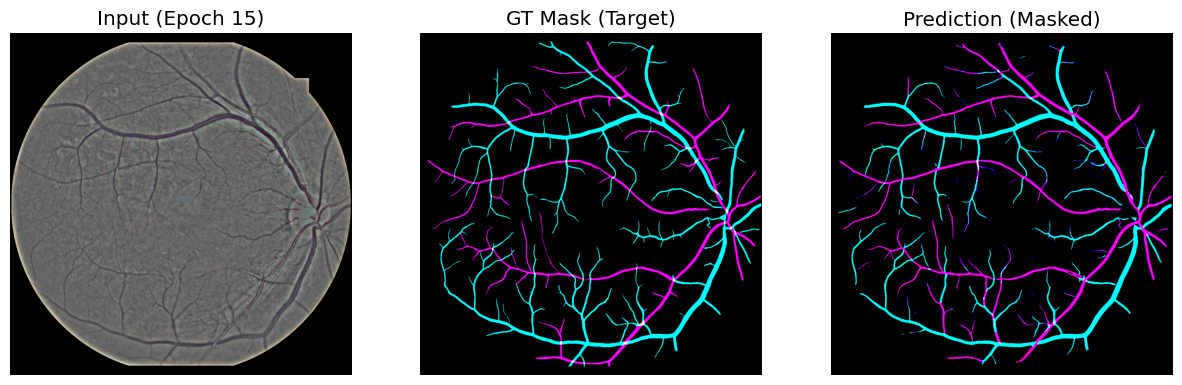

Saved new best metric model at epoch 15!
Current Best Dice: 0.8476 at epoch 15
Epoch 16/250
10/80, train_loss: 0.5649
20/80, train_loss: 0.5068
30/80, train_loss: 0.4824
40/80, train_loss: 0.5147
50/80, train_loss: 0.4218
60/80, train_loss: 0.5338
70/80, train_loss: 0.4654
80/80, train_loss: 0.4611
Average Loss: 0.5126
Epoch 17/250
10/80, train_loss: 0.4718
20/80, train_loss: 0.4589
30/80, train_loss: 0.4946
40/80, train_loss: 0.5165
50/80, train_loss: 0.4087
60/80, train_loss: 0.5509
70/80, train_loss: 0.4304
80/80, train_loss: 0.4847
Average Loss: 0.4976
Epoch 18/250
10/80, train_loss: 0.3994
20/80, train_loss: 0.6426
30/80, train_loss: 0.5575
40/80, train_loss: 0.4022
50/80, train_loss: 0.3643
60/80, train_loss: 0.4403
70/80, train_loss: 0.5239
80/80, train_loss: 0.4171
Average Loss: 0.4797
Epoch 19/250
10/80, train_loss: 0.4780
20/80, train_loss: 0.4810
30/80, train_loss: 0.4619
40/80, train_loss: 0.5139
50/80, train_loss: 0.3939
60/80, train_loss: 0.4161
70/80, train_loss: 0.3986


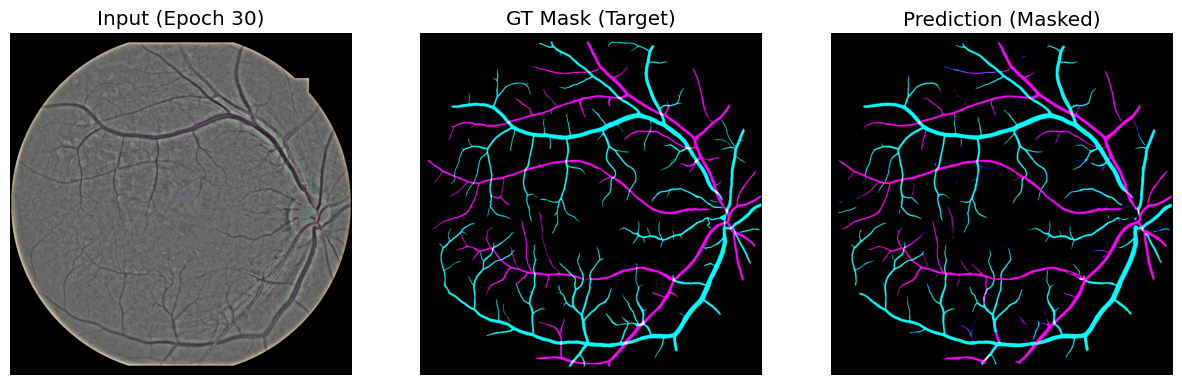

Saved new best metric model at epoch 30!
Current Best Dice: 0.8745 at epoch 30
Epoch 31/250
10/80, train_loss: 0.3811


In [ ]:
# @title 8. Loop de treinamento
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="monai.inferers.utils")

model = RRWNetSwinV2(iterations=K_ITERATIONS).to(device)

VAL_INTERVAL = 15

base_criterion = BCE3Loss()
loss_function = RRLoss(base_criterion)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dice_metric = DiceMetric(include_background=True, reduction="mean")

print(f"Initialized RRWNetSwinV2 with K={K_ITERATIONS} and RRLoss (Masking Enabled)")
print(f"Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")

def train_one_epoch(epoch_index):
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs = batch_data["image"].to(device)
        masks = batch_data["mask"].to(device)
        fov_masks = batch_data["fov_mask"].to(device)

        optimizer.zero_grad()

        outputs_list = model(inputs, mask=fov_masks)

        loss = loss_function(outputs_list, masks, mask=fov_masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if step % 10 == 0:
            print(f"{step}/{len(train_loader)}, train_loss: {loss.item():.4f}")

    return epoch_loss / step

best_metric = -1
best_metric_epoch = -1

for epoch in range(MAX_EPOCHS):
    print(f"Epoch {epoch + 1}/{MAX_EPOCHS}")
    avg_loss = train_one_epoch(epoch)
    print(f"Average Loss: {avg_loss:.4f}")

    if (epoch + 1) % VAL_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            val_inputs_vis = None
            val_masks_vis = None
            val_outputs_vis = None

            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_masks = val_data["mask"].to(device)
                val_fov = val_data["fov_mask"].to(device)

                val_input_cat = torch.cat([val_inputs, val_fov], dim=1)

                def predictor(data):
                    img = data[:, 0:3, :, :]
                    msk = data[:, 3:4, :, :]
                    return model(img, mask=msk)[-1]

                val_outputs = sliding_window_inference(
                    inputs=val_input_cat,
                    roi_size=PATCH_SIZE,
                    sw_batch_size=4,
                    predictor=predictor,
                    overlap=0.25
                )

                val_outputs = (torch.sigmoid(val_outputs) > 0.5).float()

                val_outputs = val_outputs * val_fov

                dice_metric(y_pred=val_outputs, y=val_masks)

                val_inputs_vis = val_inputs
                val_masks_vis = val_masks
                val_outputs_vis = val_outputs

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            print(f"Validation Dice: {metric:.4f}")

            if val_inputs_vis is not None:
                img_show = val_inputs_vis[0].cpu().numpy().transpose(1, 2, 0)
                mask_show = val_masks_vis[0].cpu().numpy().transpose(1, 2, 0)
                pred_show = val_outputs_vis[0].cpu().numpy().transpose(1, 2, 0)

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.title(f"Input (Epoch {epoch+1})")
                plt.imshow(img_show)
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("GT Mask (Target)")
                plt.imshow(mask_show)
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prediction (Masked)")
                plt.imshow(pred_show)
                plt.axis("off")
                plt.show()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_rrwnet_swin_v2.pth")
                print(f"Saved new best metric model at epoch {epoch+1}!")

            print(f"Current Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

In [ ]:
# @title 9. Redução do learning rate

FINE_TUNE_EPOCHS = 24
FINE_TUNE_LR = 2e-5
VAL_INTERVAL_FT = 2

# Atualizar Learning Rate no Otimizador existente
for param_group in optimizer.param_groups:
    param_group['lr'] = FINE_TUNE_LR

print(f"Iniciando Fine-tuning por {FINE_TUNE_EPOCHS} épocas com LR={FINE_TUNE_LR}")
print(f"Validando a cada {VAL_INTERVAL_FT} épocas.")
print(f"Melhor Dice atual (Global): {best_metric:.4f}")

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"Fine-tuning Epoch {epoch + 1}/{FINE_TUNE_EPOCHS}")

    avg_loss = train_one_epoch(epoch)
    print(f"Average Loss: {avg_loss:.4f}")

    if (epoch + 1) % VAL_INTERVAL_FT == 0:
        model.eval()
        with torch.no_grad():
            val_inputs_vis = None
            val_masks_vis = None
            val_outputs_vis = None

            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_masks = val_data["mask"].to(device)
                val_fov = val_data["fov_mask"].to(device)

                val_input_cat = torch.cat([val_inputs, val_fov], dim=1)

                def predictor(data):
                    img = data[:, 0:3, :, :]
                    msk = data[:, 3:4, :, :]
                    return model(img, mask=msk)[-1]

                val_outputs = sliding_window_inference(
                    inputs=val_input_cat,
                    roi_size=PATCH_SIZE,
                    sw_batch_size=4,
                    predictor=predictor,
                    overlap=0.25
                )

                val_outputs = (torch.sigmoid(val_outputs) > 0.5).float()

                val_outputs = val_outputs * val_fov

                dice_metric(y_pred=val_outputs, y=val_masks)

                val_inputs_vis = val_inputs
                val_masks_vis = val_masks
                val_outputs_vis = val_outputs

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            print(f"Validation Dice: {metric:.4f}")

            if val_inputs_vis is not None:
                img_show = val_inputs_vis[0].cpu().numpy().transpose(1, 2, 0)
                mask_show = val_masks_vis[0].cpu().numpy().transpose(1, 2, 0)
                pred_show = val_outputs_vis[0].cpu().numpy().transpose(1, 2, 0)

                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.title(f"Input (FT Epoch {epoch+1})")
                plt.imshow(img_show)
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("GT Mask")
                plt.imshow(mask_show)
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_show)
                plt.axis("off")
                plt.show()

            if metric > best_metric:
                best_metric = metric
                torch.save(model.state_dict(), "best_rrwnet_swin_v2.pth")
                print(f"Saved new best metric model!")

            print(f"Current Best Dice: {best_metric:.4f}")

In [ ]:
# @title 10. Avaliação de Dice por Canal (Artéria, Veia, Vasos)

# Carregar o melhor modelo salvo
model.load_state_dict(torch.load("best_rrwnet_swin_v2.pth"))
model.eval()

# Métrica com reduction="mean_batch" calcula a média ao longo do dataset para cada canal separadamente
# include_background=True é necessário pois nosso canal 0 é Artéria (foreground), e não fundo.
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

print("Iniciando avaliação detalhada por canal no conjunto de validação...")

with torch.no_grad():
    for val_data in val_loader:
        val_inputs = val_data["image"].to(device)
        val_masks = val_data["mask"].to(device)
        val_fov = val_data["fov_mask"].to(device)

        # Concatenar input para sliding window (Imagem + Máscara FOV)
        val_input_cat = torch.cat([val_inputs, val_fov], dim=1)

        def predictor(data):
            img = data[:, 0:3, :, :]
            msk = data[:, 3:4, :, :]
            # Pega apenas a última predição (saída final refinada)
            return model(img, mask=msk)[-1]

        val_outputs = sliding_window_inference(
            inputs=val_input_cat,
            roi_size=PATCH_SIZE,
            sw_batch_size=4,
            predictor=predictor,
            overlap=0.25
        )

        # Ativação Sigmoid e Binarização
        val_outputs = (torch.sigmoid(val_outputs) > 0.5).float()

        # Aplicar máscara FOV na predição para garantir consistência
        val_outputs = val_outputs * val_fov

        # Calcular métrica para o batch atual
        dice_metric_batch(y_pred=val_outputs, y=val_masks)

    # Agregar resultados (Média por canal em todo o dataset)
    # O resultado é um tensor de tamanho (3,) pois temos 3 canais de saída
    metric_per_channel = dice_metric_batch.aggregate()
    dice_metric_batch.reset()

    # Extrair valores individuais
    dice_artery = metric_per_channel[0].item()
    dice_vein = metric_per_channel[1].item()
    dice_vessel = metric_per_channel[2].item()

    print("-" * 40)
    print(f"Resultados Finais (Dice Score no Validation Set):")
    print(f"Dice Artéria (Canal 0): {dice_artery:.4f}")
    print(f"Dice Veia    (Canal 1): {dice_vein:.4f}")
    print(f"Dice Vasos   (Canal 2): {dice_vessel:.4f}")
    print("-" * 40)
    print(f"Média Aritmética dos 3 canais: {(dice_artery + dice_vein + dice_vessel) / 3:.4f}")

In [ ]:
from google.colab import files
import os

model_filename = "best_rrwnet_swin_v2.pth"

if os.path.exists(model_filename):
    print(f"Iniciando download de {model_filename}...")
    files.download(model_filename)
else:
    print(f"ERRO: O arquivo '{model_filename}' não foi encontrado. Verifique se o treinamento foi concluído e se o modelo foi salvo.")